# Content-based Filtering

In [1]:
import pandas as pd
import numpy as np
import time
import math
from math import sqrt
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from xgboost import XGBRegressor
import pickle

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
random.seed(42)

In [2]:
# load data
data_folder = '../data/'
user_item_ratings_reduced = pd.read_csv(f'{data_folder}user_ratings_reduced.csv')
user_item_ratings_reduced = user_item_ratings_reduced.drop(columns=["Unnamed: 0"])
item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
item_info = pd.read_csv(data_folder + 'games.csv')
item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
item_themes = pd.read_csv(data_folder + 'themes.csv')

In [3]:
# user_item_ratings_reduced['rating'] = user_item_ratings_reduced['rating'].round(0).astype(int)

In [4]:
user_item_rating_count = user_item_ratings_reduced.groupby('user').count()

In [5]:
min_rating_count = 10
user_rating_count = user_item_rating_count[user_item_rating_count['rating'] >= min_rating_count]
user_list_filtered = list(user_rating_count.index)
user_item_ratings_filtered = user_item_ratings_reduced[user_item_ratings_reduced['user'].isin(user_list_filtered)]

### Preprocessing

In [6]:
# item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
# item_info = pd.read_csv(data_folder + 'games.csv')
# item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
# item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
# item_themes = pd.read_csv(data_folder + 'themes.csv')

In [7]:
item_info.rename(columns={'BGGId':'item'},inplace=True)
# get comeplete user-catalog data
user_item_complete = pd.merge(user_item_ratings_filtered, item_info, on='item', how='inner')
# item_info.info() 
# item_info[['GoodPlayers', 'Family', 'ImagePath']].head()
non_numerical_features = ['user','Name','Description', 'item', 'GoodPlayers', 'Family', 'ImagePath']

In [8]:
# find a median rating for each user
median_rating = user_item_complete.groupby('user')['rating'].median().rename('median_rating').reset_index()
user_item_complete = pd.merge(user_item_complete, median_rating, on='user', how='inner')

User-Item matrix has size (1_228_331, 51) after selecting users with >= `min_rating_count`

User-Item matrix has size (771_551, 51) after selecting items for users with rating higher than their mean rating

In [9]:
# creating user represenations
# user_item_favourite = user_item_complete[user_item_complete['rating']>=user_item_complete['median_rating']]

# user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
# user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)

# user_representation = user_item_favourite.groupby('user').median().reset_index()
# user_representation_wnames = user_representation['user']
# user_representation.drop(columns=['user'], inplace=True)
# user_item_favourite.drop(columns=non_numerical_features, inplace=True)

### Analysis of user preference clusters
 > based on TSNE clusterings of users with similar preferences, several groups of users were investigated to check if there are differences in prederences between clusters. The analysis showed that all the groups have approximately similar preferences. Hence, no need to create different features per user group

In [10]:
# scaler = StandardScaler()
# scaled_user_represenation = scaler.fit_transform(user_representation)

In [11]:
# tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=500)
# user_clusters = tsne.fit_transform(scaled_user_represenation)

In [12]:
# user_representation['tsne-2d-one'] = user_clusters[:,0]
# user_representation['tsne-2d-two'] = user_clusters[:,1]

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     palette=sns.color_palette("hls", 10),
#     data=user_representation,
#     alpha=0.3,
# )

In [13]:
# fig = px.scatter(
#     user_representation, x=user_representation['tsne-2d-one'], y=user_representation['tsne-2d-two'],
# )
# fig.show()

In [14]:
# manual cluster extraction using upper left and lower right points
# group_1 = [(-11, 16), (12, 9.5)]
# group_2 = [(-16, 9.5), (14, 0)]
# group_3 = [(-15, 0), (15, -15)]

In [15]:
# coords_groups = [group_1, group_2, group_3]
# user_groups = []

# for bounds in coords_groups:
#     group_users = user_representation[(user_representation['tsne-2d-one'] >= bounds[0][0])&
#                                       (user_representation['tsne-2d-one'] <= bounds[1][0])&
#                                       (user_representation['tsne-2d-two'] <= bounds[0][1])&
#                                       (user_representation['tsne-2d-two'] >= bounds[1][1])]
#     user_groups.append(group_users)

In [16]:
# group_1 = user_groups[0]
# group_2 = user_groups[1]
# group_3 = user_groups[2]

# group_1 = pd.merge(group_1, user_representation_wnames, left_index=True, right_index=True, how='left')
# group_2 = pd.merge(group_2, user_representation_wnames, left_index=True, right_index=True, how='left')
# group_3 = pd.merge(group_3, user_representation_wnames, left_index=True, right_index=True, how='left')

# group_1_users = group_1.user
# group_2_users = group_2.user
# group_3_users = group_3.user

In [17]:
def get_all_items_for_user(username, complete_df):
    return complete_df[complete_df['user']==username].drop(columns=['user'])  

In [18]:
# group_1_itemids = user_item_complete[user_item_complete.user.isin(group_1_users)].item.unique()
# group_1_items = user_item_complete[user_item_complete['item'].isin(group_1_itemids)]

# group_2_itemids = user_item_complete[user_item_complete.user.isin(group_2_users)].item.unique()
# group_2_items = user_item_complete[user_item_complete['item'].isin(group_2_itemids)]

# group_3_itemids = user_item_complete[user_item_complete.user.isin(group_3_users)].item.unique()
# group_3_items = user_item_complete[user_item_complete['item'].isin(group_3_itemids)]

In [19]:
def add_avg_group_rating(selected_items, group, complete):
    selected_items.reset_index(drop=True, inplace=True)
    selected_items['avg_group_rating'] = 0
    group_users = group['user'].unique()
    for index,item in selected_items.iterrows():
        item_in_group = complete[(complete['user'].isin(group_users))&(complete['item']==item['item'])]
        average_group_rating = item_in_group['rating'].mean()
        item['avg_group_rating'] = average_group_rating
        selected_items.iloc[index,:] = item
        
    return selected_items
        

In [20]:
# item_group_1 = add_avg_group_rating(group_1_items.sample(frac=0.001, random_state=42), group_1, user_item_complete)
# item_group_2 = add_avg_group_rating(group_2_items.sample(frac=0.001, random_state=42), group_2, user_item_complete)
# item_group_3 = add_avg_group_rating(group_3_items.sample(frac=0.001, random_state=42), group_3, user_item_complete)
#item_group_1 = add_avg_group_rating(group_1_items.iloc[0:2,:], group_1, user_item_complete)

In [21]:
# all_users = pd.merge(user_representation, user_representation_wnames,left_index=True, right_index=True, how='left')
# all_items = add_avg_group_rating(user_item_complete.sample(frac=0.005, random_state=42), all_users, user_item_complete)

In [22]:
def save(obj):
    def get_variable_name(var):
        # Iterate over the global variables
        for name, value in globals().items():
            if value is var:
                return name
        return None
    name = get_variable_name(obj)
    with open("saved/"+name+".pkl", "wb") as f: # "wb" because we want to write in binary mode
        pickle.dump(obj, f)
        
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [23]:
# save(all_users)
# save(all_items)

In [24]:
# plt.figure(figsize=(16,16))
# sns.heatmap(item_group_3.corr())
# plt.title('Group 3 Correlation of Features')

In [25]:
def test_stat_significance(feature_name, selected_items,avg_rating_name):
    """ test whether an item feature has statistically significant 
        correlation (Pearson) with a group rating
    """

    feature = selected_items[feature_name].dropna()
    ratings = selected_items[avg_rating_name].reindex(feature.index).values
    feature = feature.values
    
    r, p = pearsonr(ratings, feature)
    
    significant = False
    if p < 0.05:
        significant = True

    # print(f'feature {feature_name} has p-value {round(p,2)}, significant: {significant}, correlation: {round(r,2)}')
    return r, significant
    

In [26]:
# test_stat_significance('MinPlayers',item_group_3)

In [27]:
def find_group_features(group_items, complete, avg_rating_name='avg_group_rating'):
    features = group_items.columns
    group_features = []
    for feature_name in features:
        if feature_name in non_numerical_features:
            continue
        
        correlation, significant = test_stat_significance(feature_name, group_items, avg_rating_name)
        # print(feature_name, correlation, significant)
        
        if significant and abs(correlation) > 0.10:
            group_features.append(feature_name)
    return group_features

In [28]:
# group1_features = set(find_group_features(item_group_1, user_item_complete))
# group2_features = set(find_group_features(item_group_2, user_item_complete))
# group3_features = set(find_group_features(item_group_3, user_item_complete))

In [29]:
all_items = item_info
sign_user_preferences = set(find_group_features(all_items, user_item_complete, 'AvgRating'))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [30]:
rating_features = ['AvgRating', 'BayesAvgRating', 'StdDev', 'avg_group_rating', 'median_rating']

### Item Features for Content-Based Filtering
- the features which have correlation with an average rating more than 0.15 in absolute values
- are not rating features
- are statistically significant


The features (19) were received:
```
 'Rank:boardgame',
 'Rank:strategygames',
 'Rank:childrensgames',
 'Rank:partygames',

 'NumWant',
 'NumWish',
 'NumUserRatings',
 'NumOwned',
 'NumWeightVotes',

 'BestPlayers',
 'GameWeight',
 'ComAgeRec',
 'Kickstarted',
 'MinPlayers',
 'LanguageEase',
 'MfgAgeRec'

 'Cat:Party',
 'Cat:Childrens',
 'Cat:Strategy',

 'Cat:Childrens',
 'Cat:Family',
 'Cat:Strategy',
 'Cat:Party',

 'Rank:childrensgames',
 'Rank:strategygames',
 'Rank:partygames',
 '
 
 Kickstarted',
 'ComMinPlaytime',
 'NumExpansions',
 'NumUserRatings',
 'MfgPlaytime',
 'MfgAgeRec',
 'ComMaxPlaytime',
 'MinPlayers',
 ```

Based on the analysis of the correlation of similar features from the list, the following were discarded:

 `'NumWish', 'NumWeightVotes'`

In [31]:
# item_matrix= all_items
# corr_matrix = item_matrix.corr()

# plt.figure(figsize=(16,16))
# sns.heatmap(corr_matrix)

In [49]:
from cb_features import cb_features
final_item_features = ['item','user','rating']+cb_features

In [50]:
final_item_features

['item',
 'user',
 'rating',
 'Cat:Childrens',
 'Cat:Strategy',
 'Cat:War',
 'BestPlayers',
 'ComAgeRec',
 'GameWeight',
 'IsReimplementation',
 'Kickstarted',
 'MfgAgeRec',
 'MinPlayers',
 'NumExpansions',
 'NumImplementations',
 'NumOwned',
 'NumWant',
 'NumWeightVotes',
 'Rank:boardgame',
 'Rank:childrensgames',
 'Rank:strategygames',
 'Rank:thematic',
 'Rank:wargames']

In [38]:
mechanics_features = ['mechanic_' + i if not i == 'BGGId' else i for i in item_mecahnics.columns]
subcategory_features = ['subcategory_' + i if not i == 'BGGId' else i for i in item_subcategories.columns]
theme_features = ['theme_' + i.split('_')[-1] if not i == 'BGGId' else i for i in item_themes.columns]

item_mecahnics.columns = mechanics_features
item_subcategories.columns = subcategory_features
item_themes.columns = theme_features

item_catalog = pd.merge(item_mecahnics, item_subcategories, on='BGGId', how='outer')
item_catalog = pd.merge(item_catalog, item_themes, on='BGGId', how='outer')

In [51]:
user_item_selected = user_item_complete[final_item_features]
user_item_all_features = pd.merge(user_item_selected, item_catalog, left_on='item', right_on='BGGId', how='left')

In [53]:
user_item_all_features.select_dtypes(include=['object']).columns

Index(['user'], dtype='object')

In [54]:
# nan_counts = user_item_all_features.isna().sum(axis=0)
# nan_counts[nan_counts > 0]

In [55]:
all_user_names = user_item_all_features.user.unique()

In [56]:
def generate_Xy_for_user(username, complete_df):
    scaler = StandardScaler()
    user_rated_items = complete_df[complete_df['user']==username]
    index_x = user_rated_items.index
    X = user_rated_items.drop(columns=['user','rating', 'item'])
    normalized_matrix = scaler.fit_transform(X)
    X =  pd.DataFrame(normalized_matrix, columns=X.columns, index=index_x)
    y = user_rated_items['rating']
    return X,y

In [57]:
X,y = generate_Xy_for_user(all_user_names[0],user_item_all_features[final_item_features])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2, random_state=42)

In [58]:
svr = SVR(kernel='linear')
svr.fit(train_X, train_y)

SVR(kernel='linear')

In [59]:
predicted_y = svr.predict(test_X)

In [60]:
item_rating = test_y.to_frame().copy()
item_rating['predicted'] = predicted_y

## Evaluation

In [78]:
num_users_test = 1000
users_for_test = random.sample(list(all_user_names), num_users_test)

In [79]:
# RMSE
((item_rating['rating']-item_rating['predicted'])**2).mean(0)**0.5

1.3320130707474829

In [80]:
# MAE
(abs(item_rating['rating']-item_rating['predicted'])).mean(0)

1.0365994635882825

In [81]:
def evaluate_users(users, user_item_all_features, regressor):
    RMSEs = []
    MAEs = []
    for user in users:
        X,y = generate_Xy_for_user(user,user_item_all_features)
        train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
        
        regressor.fit(train_X, train_y)
        predicted_y = regressor.predict(test_X)
        
        item_ratings = test_y.to_frame().copy()
        item_ratings['predicted'] = predicted_y
        
        RMSEs.append(((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5)
        MAEs.append((abs(item_ratings['rating']-item_ratings['predicted'])).mean(0))
        
    return RMSEs, MAEs

In [82]:
# missing_values_counts = user_item_all_features.isna().sum(axis=0)

# # Print the counts of missing values for rows where there are NaN values
# print(missing_values_counts[missing_values_counts > 0])

In [83]:
user_item_all_features['ComAgeRec'].fillna(value=user_item_all_features['ComAgeRec'].mean(), inplace=True)
#user_item_all_features['LanguageEase'].fillna(value=user_item_all_features['LanguageEase'].mean(), inplace=True)

In [84]:
regressor = SVR(kernel='linear')
RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [85]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)

In [86]:
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.59  | MAE: 1.33


In [87]:
regressor = DecisionTreeRegressor()
RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [88]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.5  | MAE: 1.24


In [76]:
regressor = XGBRegressor()
RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [77]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.0  | MAE: 0.75


# Generating Explanations

In [90]:
random_user = random.sample(list(all_user_names), 1)[0]
random_user

'eightbit'

In [91]:
tree_regressor = DecisionTreeRegressor(random_state=42)

In [92]:
X, y = generate_Xy_for_user(random_user, user_item_all_features[final_item_features])

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
tree_regressor.fit(train_X, train_y)
predicted_y = tree_regressor.predict(test_X)

item_ratings = test_y.to_frame().copy()
item_ratings['predicted'] = predicted_y
        
RMSE = ((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5
MAE = (abs(item_ratings['rating']-item_ratings['predicted'])).mean(0)

In [93]:
interacted_items = user_item_complete[user_item_complete.index.isin(X.index)]

In [94]:
test_items = user_item_complete[user_item_complete.index.isin(test_X.index)]

In [95]:
# text_representation = tree.export_text(tree_regressor)
# print(text_representation)

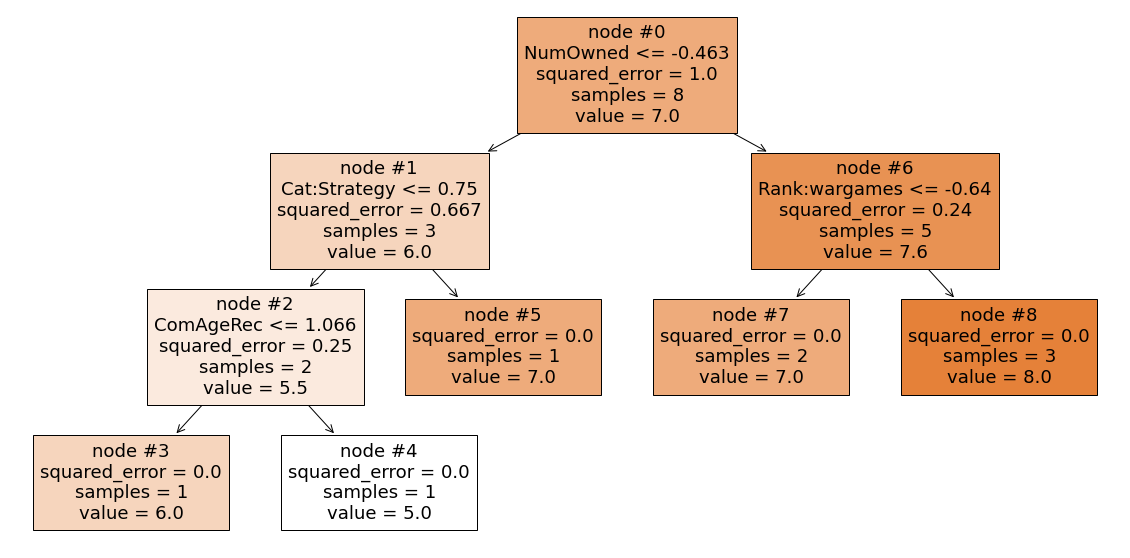

In [96]:
# Plot the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(tree_regressor, filled=True, feature_names=X.columns,node_ids=True)
plt.show()

In [99]:
# calculate feature importances for a prediction

# select features used to create a prediction
decision_path = tree_regressor.decision_path([test_X.iloc[0,:]])
node_indices = decision_path.indices
feature_indices = tree_regressor.tree_.feature
feature_names = test_X.columns  # Replace with your actual feature names
used_features = [feature_names[i] for i in feature_indices[node_indices] if i > 0]
used_features

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


['NumOwned', 'Cat:Strategy', 'ComAgeRec']

In [100]:
def get_features_sorted(selected_featurenames, feature_names, feature_importances):
    # Create a list of tuples (feature_name, feature_importance)
    feature_importance_tuples = list(zip(feature_names, feature_importances))
    
    # Sort the list of tuples by feature importance in descending order
    sorted_features = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
    sorted_features = [s for s in sorted_features if s[0] in selected_featurenames]
    return sorted_features

In [101]:
get_features_sorted(used_features, test_X.columns, tree_regressor.feature_importances_)

[('NumOwned', 0.5999999999999996),
 ('Cat:Strategy', 0.1874999999999991),
 ('ComAgeRec', 0.0625)]

In [102]:
node_indicator = decision_path
leaf_id = tree_regressor.apply([test_X.iloc[0,:]])
for node_id in node_indices:
    # continue to the next node if it is a leaf node
    # if leaf_id[sample_id] == node_id:
    #     continue
    if node_id==leaf_id:
        continue
    
    print(
        "decision node {node} : X_test[{sample},{feature}]".format(
            node=node_id,
            sample=node_id,
            feature=feature_indices[node_id],
        )
    )


decision node 0 : X_test[0,12]
decision node 1 : X_test[1,1]
decision node 2 : X_test[2,4]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


### Showcase

In [104]:
user = random.sample(list(all_user_names), num_users_test)[0]
X, y = generate_Xy_for_user(user, user_item_all_features[final_item_features])
print(f"Username: {user} | Number of interactions: {X.shape[0]}")

Username: Rikmay | Number of interactions: 45


In [134]:
# train a tree
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
tree_regressor.fit(train_X, train_y)
predicted_y = tree_regressor.predict(test_X)

item_ratings = test_y.to_frame().copy()
item_ratings['predicted'] = predicted_y
        
RMSE = ((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5
MAE = (abs(item_ratings['rating']-item_ratings['predicted'])).mean(0)

interacted_items = user_item_complete[user_item_complete.index.isin(X.index)]
test_items = user_item_complete[user_item_complete.index.isin(test_X.index)]
important_features = ['Name']+final_item_features

In [135]:
def explain_prediction(item_data, test_X, tree_reg, k=3):
    """ will explain the recommendation using top k important features for the particular item"""
    item_id = item_data.name
    item_Name = item_data.Name
    test_ids = test_X.index
    if item_id not in test_ids:
        return "No such item in the test set"
    
    decision_path = tree_regressor.decision_path([test_X.loc[item_id,:]])
    node_indices = decision_path.indices
    feature_indices = tree_regressor.tree_.feature
    feature_names = test_X.columns 
    #print(feature_names)
    used_features = [feature_names[i] for i in feature_indices[node_indices] if i > 0]
    # print(used_features)
    selected_features = get_features_sorted(used_features, feature_names, tree_regressor.feature_importances_)
    # print(selected_features)
    
    explaining_fs = []
    for f in selected_features:
        explaining_fs.append(f[0])
    
    #print(selected_features)
    k = min(len(explaining_fs), k)
        
    if len(explaining_fs):
        # return f"The game '{item_Name}' is recommended to you because you like games in the following categories: {', '.join(explaining_fs)}"
        return explaining_fs[:k], item_Name

In [139]:
item = test_items[important_features].sample(1).iloc[0]
exp_fs,gname = explain_prediction(item, test_X, tree_regressor, k=3)
exp_fs,gname

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(['NumWant', 'MfgAgeRec', 'Cat:War'], 'Brotherhood & Unity')

In [140]:
rank_fs = {'Rank:boardgame':'general','Rank:strategygames':'strategy','Rank:childrensgames':'children','Rank:thematic':'thematic', 'Rank:wargames':'war'}
num_fs = {'NumWant':'which are wanted by many other users','NumOwned':'which are owned by many other users','NumExpansions':'with a high number of expansions','NumImplementations':'with a high number of implementations'}
cat_fs = {'Cat:War':'war','Cat:Childrens':'childrens','Cat:Strategy':'strategy'}
other_fs = {
    'BestPlayers':'the optimal number of players indicated by the community',
    'GameWeight':'easiness/difficulty of a game',
    'ComAgeRec':'the common age to play a game',
    'Kickstarted':'whether a game is kickstarted or not',
    'MinPlayers':'the minimum number of players',
    'IsReimplementation':'how many reimplementations a game has',
    'MfgAgeRec':'the recommended age indicated by the manufacturer'
    }
connectors = {0:'', 1:'Also, ', 2:'At the same time, ', 3:'Finally, '}

def write_explanation(explanation_fs, game_name):
    print(f'INPUT: Features: {explanation_fs}, game: [{game_name}]')
    rank_exp = 'we noticed that you like board games ranked high in the '
    num_exp = 'we found that you like board games '
    cat_exp = 'we observed that you like board games in '
    other_exp = 'we spotted that you put a lot of emphasis on '
    connector = ''
    count = 0
    
    explanation = f'The game {game_name} is recommended to you because '
    
    # rank explanation
    rank_active_exps = [rank_fs[f] for f in explanation_fs if f in rank_fs.keys()]
    if len(rank_active_exps) > 1:
        explanation += rank_exp + ', '.join(rank_active_exps) + ' rankings.\n'
        count += 1
    elif len(rank_active_exps) == 1:
        explanation += rank_exp + rank_active_exps[0] + ' ranking.\n'
        count += 1
        
    # count explanation
    num_active_exps = [num_fs[f] for f in explanation_fs if f in num_fs.keys()]
    if len(num_active_exps) > 1:
        explanation += connectors[count] + num_exp + ', '.join(num_active_exps) + ' .\n'
        count += 1
    elif len(num_active_exps) == 1:
        explanation += connectors[count] + num_exp + num_active_exps[0] + ' .\n'
        count += 1
        
    # category explanations
    cat_active_exps = [cat_fs[f] for f in explanation_fs if f in cat_fs.keys()]
    if len(cat_active_exps) > 1:
        explanation += connectors[count] + cat_exp + ', '.join(cat_active_exps) + ' categories.\n'
        count += 1
    elif len(cat_active_exps) == 1:
        explanation += connectors[count] + cat_exp + cat_active_exps[0] + ' category.\n'
        count += 1
    
    other_active_exps = [other_fs[f] for f in explanation_fs if f in other_fs.keys()]
    if len(other_active_exps) > 1:
        explanation += connectors[count] + other_exp  + ', '.join(other_active_exps) + ' when selecting games.\n'
    elif len(other_active_exps) == 1:
        explanation += connectors[count] + other_exp + other_active_exps[0] + ' when selecting games.\n'
        
    return explanation    

In [141]:
print(write_explanation(exp_fs, gname))

INPUT: Features: ['NumWant', 'MfgAgeRec', 'Cat:War'], game: [Brotherhood & Unity]
The game Brotherhood & Unity is recommended to you because we found that you like board games which are wanted by many other users .
Also, we observed that you like board games in war category.
At the same time, we spotted that you put a lot of emphasis on the recommended age indicated by the manufacturer when selecting games.



Ex1: 
```
INPUT: Features: ['NumWant', 'MfgAgeRec', 'GameWeight'], game: [Codenames: Pictures]
The game Codenames: Pictures is recommended to you because we found that you like board games which are wanted by many other users .
Also, we spotted that you put a lot of emphasis on the recommended age indicated by the manufacturer, easiness/difficulty of a game when selecting games.
```

Ex2:
```
INPUT: Features: ['NumWant', 'MfgAgeRec', 'GameWeight'], game: [Viticulture]
The game Viticulture is recommended to you because we found that you like board games which are wanted by many other users .
Also, we spotted that you put a lot of emphasis on the recommended age indicated by the manufacturer, easiness/difficulty of a game when selecting games.
```

Ex3:
```
INPUT: Features: ['NumWant', 'MfgAgeRec', 'Cat:War'], game: [Brotherhood & Unity]
The game Brotherhood & Unity is recommended to you because we found that you like board games which are wanted by many other users .
Also, we observed that you like board games in war category.
At the same time, we spotted that you put a lot of emphasis on the recommended age indicated by the manufacturer when selecting games.
```